# 高级技术


在这节课中，我们将探索一些技术，以提高神经网络的可靠性和训练便利性。
为了说明这些技术，我们将使用 [MNIST](https://fr.wikipedia.org/wiki/Base_de_donn%C3%A9es_MNIST) 数据集，该数据集包含手写数字 1 到 9 的图像。
我们的目标是让网络接受图像作为输入，并识别图像代表的数字。


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

## 数据集的创建


首先，我们下载 MNIST 数据集。torchvision 库允许我们用 PyTorch 处理图像，并提供了加载常见数据集的工具。


In [4]:
transform=T.ToTensor() # Pour convertir les éléments en tensor torch directement
dataset = datasets.MNIST(root='./../data', train=True, download=True,transform=transform)
test_dataset = datasets.MNIST(root='./../data', train=False,transform=transform)

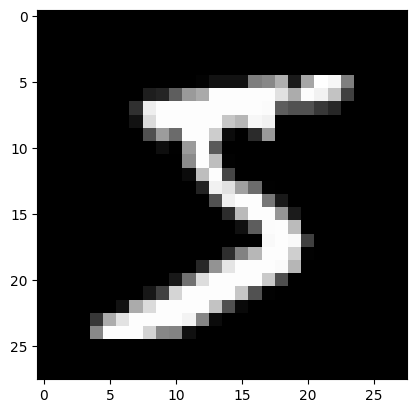

Le chiffre sur l'image est un 5


In [5]:
# On peut visualiser les éléments du dataset
plt.imshow(dataset[0][0].permute(1,2,0).numpy(), cmap='gray')
plt.show()
print("Le chiffre sur l'image est un "+str(dataset[0][1]))

## 训练/验证/测试数据的分离


如你所见，在加载数据集时，我们得到了一个 *train_dataset* 和一个 *test_dataset*。这是训练神经网络的一个重要实践。
实际上，在训练数据上的网络在同一数据上表现良好。因此，我们需要创建一个 *测试数据集* 来评估模型在训练过程中未见过的数据上的性能。

实际上，我们使用 3 个子数据集：
- *训练集* 用于模型的训练。
- *验证集* 用于在训练过程中评估模型。
- *测试集* 用于训练结束后评估模型（这是最重要的结果）。

常见的做法是使用 60-20-20 的划分，即 60% 的数据用于训练，20% 用于验证，20% 用于测试。然而，这个建议并不适用于所有数据集。如果数据集包含大量图像，我们可以减少验证和测试数据的比例。例如，对于包含数十亿图像的数据集，我们通常使用 98-1-1 或甚至 99.8-0.1-0.1 的划分。


In [6]:
#Le train et test sont déjà séparé, on va donc séparer le train_dataset en train et validation
train_dataset, validation_dataset=torch.utils.data.random_split(dataset, [0.8,0.2])

# Création des dataloaders pour séparer en mini-batch automatiquement
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader= DataLoader(validation_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## 创建和训练第一个模型


与之前的笔记本一样，我们创建一个全连接模型进行训练。由于输入数据是 $28 \times 28$ 大小的图像，我们需要将它们转换为 $28 \times 28=784$ 大小的 1D 向量以便输入到网络中。


In [8]:
class mlp(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.fc1=nn.Linear(784,256) # première couche cachée 
    self.fc2=nn.Linear(256,256) # seconde couche cachée 
    self.fc3=nn.Linear(256,10) # couche de sortie
    
  # La fonction forward est la fonction appelée lorsqu'on fait model(x)
  def forward(self,x):
    x=x.view(-1,28*28) # Pour convertir l'image de taille 28x28 en tensor de taille 784
    x=F.relu(self.fc1(x)) # le F.relu permet d'appliquer la fonction d'activation ReLU sur la sortie de notre couche 
    x=F.relu(self.fc2(x))
    output=self.fc3(x)
    return output

In [10]:
model = mlp()
print(model)
print("Nombre de paramètres", sum(p.numel() for p in model.parameters()))

mlp(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)
Nombre de paramètres 269322


### 损失函数


对于损失函数，我们使用 PyTorch 的 *交叉熵损失*，它对应于逻辑回归损失函数，适用于超过 2 个类别的情况。
损失函数如下：
$\text{Cross Entropy Loss} = -\frac{1}{N} \sum_{i=1}^{N} \sum_{c=1}^{C} y_{ic} \log(p_{ic})$
其中：
- $N$ 是 *mini-batch* 中的样本数量。
- $C$ 是类别数量。
- $y_{ic}$ 是目标值（如果样本属于类别 $c$，则为 1，否则为 0）。
- $p_{ic}$ 是属于类别 $c$ 的预测概率。


In [11]:
# En pytorch
criterion = nn.CrossEntropyLoss()

### 超参数和训练


In [12]:
epochs=5
learning_rate=0.001
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

模型训练（可能需要几分钟，具体取决于你的计算机性能）。


In [13]:
for i in range(epochs):
  loss_train=0
  for images, labels in train_loader:
    preds=model(images)
    loss=criterion(preds,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_train+=loss   
  if i % 1 == 0:
    print(f"step {i} train loss {loss_train/len(train_loader)}")
  loss_val=0    
  for images, labels in val_loader:
    with torch.no_grad(): # permet de ne pas calculer les gradients
      preds=model(images)
      loss=criterion(preds,labels)
      loss_val+=loss 
  if i % 1 == 0:
    print(f"step {i} val loss {loss_val/len(val_loader)}")

step 0 train loss 0.29076647758483887
step 0 val loss 0.15385286509990692
step 1 train loss 0.10695428401231766
step 1 val loss 0.10097559541463852
step 2 train loss 0.07086848467588425
step 2 val loss 0.09286081790924072
step 3 train loss 0.05028771981596947
step 3 val loss 0.08867377787828445
step 4 train loss 0.04254501312971115
step 4 val loss 0.0835222601890564


### 在测试数据上验证模型


现在模型已经训练完成，我们可以在 *测试集* 上验证其性能。


In [14]:
correct = 0
total = 0
for images,labels in test_loader: 
  with torch.no_grad():
    preds=model(images)
    
    _, predicted = torch.max(preds.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()     
test_acc = 100 * correct / total
print("Précision du modèle en phase de test : ",test_acc)

Précision du modèle en phase de test :  97.69


我们的模型在测试阶段取得了非常好的精度，这是一个好兆头。
然而，我们注意到在训练过程中，*训练损失* 比 *验证损失* 低。这是一个需要考虑的重要点，因为这意味着模型有轻微的 *过拟合*。


## 过拟合和欠拟合


深度学习的一个关键点是模型不 *过拟合* 训练数据的能力。*过拟合* 对应于一个模型在训练数据上学习得太好，但无法对来自同一分布的新元素进行泛化。
为了理解这个原理，这里有一个图表，展示了 *欠拟合*（模型过于简单，无法学习数据的复杂性）、一个良好训练的模型和 *过拟合* 之间的区别。

![Overfitting](./images/overfitting.png)


在 *过拟合* 最严重的情况下，模型在训练数据上几乎达到完美的精度，但在验证和测试数据上表现不佳。
在这节课中，我们将介绍 2 种方法来避免这个 *过拟合* 的问题。


### L2 正则化


L2 正则化是一种方法，它通过基于模型权重值的损失惩罚来实现。这个惩罚与模型权重值的平方成正比（需要注意的是，还存在 L1 正则化，它与模型权重值线性成正比）。这个惩罚鼓励模型的权重保持较小，并对训练数据的噪声不太敏感。
我们可以这样表达 L2 正则化：
$L(w) = L_0(w) + \lambda \sum_{i=1}^{n} w_i^2$
其中：
- $L(w)$ 是正则化后的损失。
- $L_0(w)$ 是经典的损失函数。
- $\lambda$ 是正则化系数。
- $w_i$ 是模型的一个权重。

要了解更多关于 L2 正则化的知识，你可以参考 [关于正则化的加分课程](../Bonus_CoursSpécifiques/06_Regularisation.ipynb) 或这篇 [博客文章](https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c)。


现在我们重新进行训练，并添加正则化。在 PyTorch 中，正则化通过在 *优化器* 中添加 *weight_decay* 参数来实现。*weight_decay* 的值对应于前面方程中的 $\lambda$。


In [15]:
model_with_reg=mlp()
epochs=5
learning_rate=0.001
optimizer=torch.optim.Adam(model_with_reg.parameters(),lr=learning_rate,weight_decay=1e-5)

for i in range(epochs):
  loss_train=0
  for images, labels in train_loader:
    preds=model_with_reg(images)
    loss=criterion(preds,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_train+=loss   
  if i % 1 == 0:
    print(f"step {i} train loss {loss_train/len(train_loader)}")
  loss_val=0    
  for images, labels in val_loader:
    with torch.no_grad(): # permet de ne pas calculer les gradients
      preds=model_with_reg(images)
      loss=criterion(preds,labels)
      loss_val+=loss 
  if i % 1 == 0:
    print(f"step {i} val loss {loss_val/len(val_loader)}")

step 0 train loss 0.2986273467540741
step 0 val loss 0.1439662128686905
step 1 train loss 0.11165566742420197
step 1 val loss 0.10781095176935196
step 2 train loss 0.07492929697036743
step 2 val loss 0.09555892646312714
step 3 train loss 0.05378309637308121
step 3 val loss 0.08672302216291428
step 4 train loss 0.041800014674663544
step 4 val loss 0.0883878618478775


In [16]:
correct = 0
total = 0
for images,labels in test_loader: 
  with torch.no_grad():
    preds=model_with_reg(images)
    
    _, predicted = torch.max(preds.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()     
test_acc = 100 * correct / total
print("Précision du modèle en phase de test : ",test_acc)

Précision du modèle en phase de test :  97.73


差异并不明显，但我们注意到验证损失和训练损失之间的差异有所减少。


**直觉**：L2 正则化之所以有效，是因为通过惩罚大系数，它促成了权重更均匀分布的解。这减少了模型对训练数据特定变化的敏感性，从而提高了模型的健壮性和泛化能力。


### Dropout


另一种正则化方法是 *Dropout*。这种方法在训练的每一步中，随机地禁用网络中的一部分神经元（禁用的权重在训练过程中会变化）。每个层中的每个神经元都有一个概率 $p$ 被禁用。

这种技术迫使网络不依赖于特定的神经元，而是学习更健壮且泛化更好的表示。我们可以将 *Dropout* 视为一种模型集合，其中每个模型都不同（因为某些神经元被禁用）。在测试阶段，我们取这些不同模型的“平均值”。在测试阶段，*Dropout* 被禁用。


要应用 *Dropout*，需要直接在网络架构中添加它。


In [17]:
class mlp_dropout(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.fc1=nn.Linear(784,256) 
    self.dropout1 = nn.Dropout(0.2) # on désactive 20% des neurones aléatoirement
    self.fc2=nn.Linear(256,256) 
    self.dropout2 = nn.Dropout(0.2) # on désactive 20% des neurones aléatoirement
    self.fc3=nn.Linear(256,10) 
  
  def forward(self,x):
    x=x.view(-1,28*28)
    x=F.relu(self.dropout1(self.fc1(x)))
    x=F.relu(self.dropout2(self.fc2(x)))
    output=self.fc3(x)
    return output

In [18]:
model_with_dropout=mlp_dropout()
epochs=5
learning_rate=0.001
optimizer=torch.optim.Adam(model_with_dropout.parameters(),lr=learning_rate)

for i in range(epochs):
  loss_train=0
  for images, labels in train_loader:
    preds=model_with_dropout(images)
    loss=criterion(preds,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_train+=loss   
  if i % 1 == 0:
    print(f"step {i} train loss {loss_train/len(train_loader)}")
  loss_val=0    
  for images, labels in val_loader:
    with torch.no_grad(): # permet de ne pas calculer les gradients
      preds=model_with_dropout(images)
      loss=criterion(preds,labels)
      loss_val+=loss 
  if i % 1 == 0:
    print(f"step {i} val loss {loss_val/len(val_loader)}")

step 0 train loss 0.3267715573310852
step 0 val loss 0.19353896379470825
step 1 train loss 0.13504144549369812
step 1 val loss 0.14174170792102814
step 2 train loss 0.10012412816286087
step 2 val loss 0.13484247028827667
step 3 train loss 0.07837768644094467
step 3 val loss 0.10895466059446335
step 4 train loss 0.0631122887134552
step 4 val loss 0.10599609464406967


In [25]:
correct = 0
total = 0
for images,labels in test_loader: 
  with torch.no_grad():
    preds=model_with_dropout(images)
    
    _, predicted = torch.max(preds.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()     
test_acc = 100 * correct / total
print("Précision du modèle en phase de test : ",test_acc)

Précision du modèle en phase de test :  96.96


我们再次看到训练结果有所改善。


**直觉**：*Dropout* 通过在训练过程中随机禁用神经元来改善泛化能力。这防止了模型过度依赖某些神经元，并促成了更健壮和多样化的特征分布。


## 批量归一化


另一种改善神经网络训练的技术是 *批量归一化*（*BatchNorm*）。其原理是用均值为零、方差为 1 的分布对网络的每个层的输入进行归一化。
归一化是在整个 *mini-batch* 上进行的，具体如下：

对于一个 *mini-batch* $B$ 和激活值 $x$：
- $\mu_B = \frac{1}{m} \sum_{i=1}^m x_i$：$m$ 个元素的激活值 $x_i$ 的均值。
- $\sigma_B^2 = \frac{1}{m} \sum_{i=1}^m (x_i - \mu_B)^2$：$m$ 个元素的激活值 $x_i$ 的方差。
- $\hat{x}_i = \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}$：$x_i$ 的归一化值。
- $y_i = \gamma \hat{x}_i + \beta$：添加参数 $\gamma$ 和 $\beta$ 允许网络学习最佳的激活分布。

其中：
- $m$ 是 *mini-batch* $B$ 的大小。
- $\epsilon$ 是一个用于避免除以零的小常数。
- $\gamma$ 和 $\beta$ 是可学习的参数。


实际上，使用 *BatchNorm* 时，我们注意到 4 个主要优点：
- **加速训练**：对每个层的输入进行归一化，允许使用更高的 *学习率*，从而加速训练的收敛。
- **减少对权重初始化的敏感性**：*BatchNorm* 允许稳定激活值的分布，使网络对权重的初始化不那么敏感。
- **改善泛化能力**：与 *Dropout* 和 L2 正则化一样，*BatchNorm* 作为一种正则化形式。这归因于通过在 *batch* 上进行归一化所引入的噪声。
- **减少“内部协变量移位”**：在整个网络中稳定激活值，可以减少内部层的分布变化，从而简化学习。

需要记住的是，*BatchNorm* 提供了许多优点，因此建议始终使用它。

还存在其他归一化技术，如 *LayerNorm*、*InstanceNorm*、*GroupNorm* 等。
要了解更多关于 *批量归一化* 的知识，你可以完成 [关于 *批量归一化* 的加分课程](../Bonus_CoursSpécifiques/02_BatchNorm.ipynb)、阅读 [论文](https://arxiv.org/pdf/1502.03167) 或阅读 [博客文章](https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739)。
要了解更多关于归一化对神经网络训练重要性的信息，你可以参考 [博客文章](https://medium.com/nerd-for-tech/overview-of-normalization-techniques-in-deep-learning-e12a79060daf)。


要在 PyTorch 中实现 *BatchNorm*，需要在模型的构建过程中直接添加它。需要注意的是，我们通常在激活函数之前应用 *BatchNorm*，但两种方法都是可能的（在前或之后）。


In [26]:
class mlp_bn(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.fc1=nn.Linear(784,256) 
    self.bn1=nn.BatchNorm1d(256) # Batch Normalization
    self.fc2=nn.Linear(256,256) 
    self.bn2=nn.BatchNorm1d(256) # Batch Normalization
    self.fc3=nn.Linear(256,10) 
  
  def forward(self,x):
    x=x.view(-1,28*28)
    x=F.relu(self.bn1(self.fc1(x)))
    x=F.relu(self.bn1(self.fc2(x)))
    output=self.fc3(x)
    return output

In [27]:
model_with_bn=mlp_bn()
epochs=5
learning_rate=0.001
optimizer=torch.optim.Adam(model_with_bn.parameters(),lr=learning_rate)

for i in range(epochs):
  loss_train=0
  for images, labels in train_loader:
    preds=model_with_bn(images)
    loss=criterion(preds,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_train+=loss   
  if i % 1 == 0:
    print(f"step {i} train loss {loss_train/len(train_loader)}")
  loss_val=0    
  for images, labels in val_loader:
    with torch.no_grad(): # permet de ne pas calculer les gradients
      preds=model_with_bn(images)
      loss=criterion(preds,labels)
      loss_val+=loss 
  if i % 1 == 0:
    print(f"step {i} val loss {loss_val/len(val_loader)}")

step 0 train loss 0.20796926319599152
step 0 val loss 0.1327729970216751
step 1 train loss 0.09048832952976227
step 1 val loss 0.10177803039550781
step 2 train loss 0.0635765939950943
step 2 val loss 0.09861738979816437
step 3 train loss 0.045849185436964035
step 3 val loss 0.09643400460481644
step 4 train loss 0.0397462323307991
step 4 val loss 0.08524414896965027


In [28]:
correct = 0
total = 0
for images,labels in test_loader: 
  with torch.no_grad():
    preds=model_with_bn(images)
    
    _, predicted = torch.max(preds.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()     
test_acc = 100 * correct / total
print("Précision du modèle en phase de test : ",test_acc)

Précision du modèle en phase de test :  97.19


如你所见，*BatchNorm* 允许我们在相同的训练条件下获得更好的数据分数。
